This will be my notebook for conducting speedy Bayesian mixed-effects logistic regression.


Notes
___


- Bambi needs update xarray (for 'unify_chunks' method), while the data I pickled used xarray 0.13.0 


- Bambi can't multi-process sampling across multiple chains if you import joblib, so need to make sure to only load in csv data. 

In [2]:
import arviz as az
import bambi as bmb
import argparse
from os.path import join
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from Bayesian_model_utils import run_model, plot_res, print_latex_table, plot_predictions

In [3]:
# Make a graphical model of the neural stuff
# Model 4: Examine the effect of HFA power and word features on recall. 

# pow_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/LM_data_128_30_noIED.csv')
pow_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/LM_data_128_30_ELEC_RESOLVED.csv')
pow_df = pow_df.drop(columns=['Unnamed: 0'])

# rename the electrodes to properly do the elec random effects 
pow_df.elec = pow_df.apply(lambda x: f'{x.subj}_{x.elec}', axis=1)

# # average across electrodes in a region(subj/region/hemi/ybin) but keep words (arousal/valence/memory) (for speed!)
# pow_df = pow_df.groupby(['arousal','valence','subj','region','hemi', 'memory', 'band']).mean().reset_index()

# De-mean the valence  
pow_df['valence'] = pow_df['valence'] - 0.5

# Set categorical orders 

cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
pow_df.hemi = pow_df.hemi.astype(cat_type)

# Let's do separate models for band

for band in ['hfa']:
        
    pow_df = pow_df[pow_df.band==band]

    y = 'memory'
    X = ['arousal', 'valence', 'region', 'power', 'hemi'] 
    Intx = ['arousal:valence',
            'power:arousal', 
            'power:valence',
            'power:hemi',
            'power:region',
            'power:region:hemi',
            'power:arousal:hemi',
            'power:valence:hemi',
            'power:arousal:valence',
            'power:arousal:region', 
            'power:valence:region']

    label = (f"{y}" + "_{}"*len(X)).format(*X) + f'_{band}' + 'elec_rand_effect'

#             'power:hemi:region:arousal',
#             'power:hemi:region:CV'
    rand_effect = ['subj', 'elec']
    categorical = ['hemi', 'region']

    # Drop nan data
    pow_df = pow_df.dropna(subset=X)
    
    rand_term = [f'(1|{x})' for x in rand_effect]
    formula = f'{y} ~ 1+'+'+'.join(rand_term)+'+'+'+'.join(X)+'+'+'+'.join(Intx)
    model_fam = 'bernoulli'
    priors=None
    categorical=None
    # construct the model 
    model = bmb.Model(formula=formula, 
                  data=pow_df[rand_effect + [y] + X],
                 family=model_fam,
                 priors=priors,
                 categorical=categorical)
    
    model.build()

/home1/salman.qasim/miniconda3/envs/bambi_env/lib/python3.10/site-packages/bambi/models.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[obj_cols] = data[obj_cols].apply(lambda x: x.astype("category"))


In [ ]:
model.plot_priors()

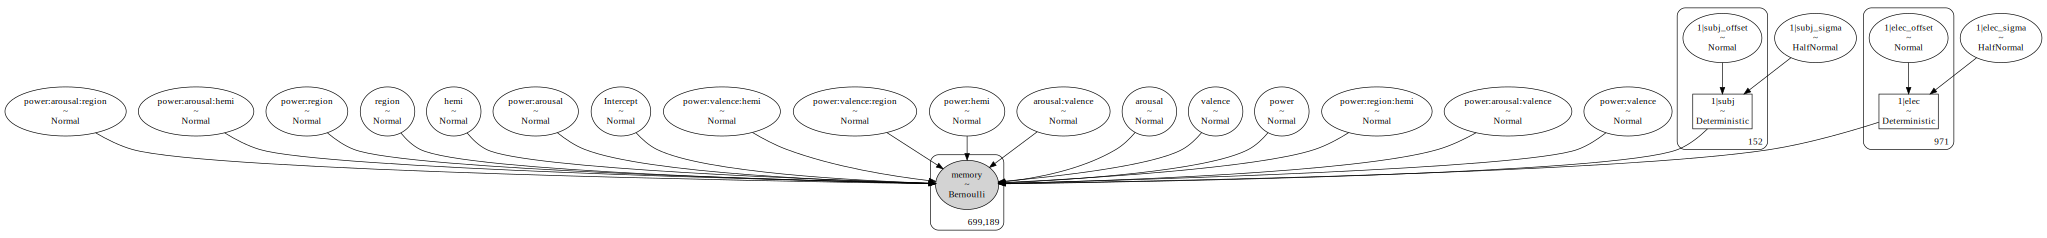

In [4]:
model.graph()

In [12]:
pow_df

,power,region,memory,arousal,valence,band,y_coord,hemi,subj,elec,CA,CV
600,0.767419,Hipp,0,0.135,0.087,hfa,-26.76,left,R1001P,R1001P_LDH1-LDH2,low,neutral
601,1.166443,Hipp,0,0.530,0.083,hfa,-26.76,left,R1001P,R1001P_LDH1-LDH2,med,neutral
602,1.398337,Hipp,0,0.322,0.042,hfa,-26.76,left,R1001P,R1001P_LDH1-LDH2,low,neutral
604,0.142283,Hipp,0,0.418,0.333,hfa,-26.76,left,R1001P,R1001P_LDH1-LDH2,med,pos
605,0.701030,Hipp,0,0.133,0.240,hfa,-26.76,left,R1001P,R1001P_LDH1-LDH2,low,pos
...,...,...,...,...,...,...,...,...,...,...,...,...
1475578,-0.473307,Amy,0,0.200,0.052,hfa,NaN,left,R1409D,R1409D_LAD4-LAD5,low,neutral
1475579,-1.179263,Amy,0,0.277,0.031,hfa,NaN,left,R1409D,R1409D_LAD4-LAD5,low,neutral
1475580,-0.055205,Amy,0,0.255,0.250,hfa,NaN,left,R1409D,R1409D_LAD4-LAD5,low,pos
1475582,-1.011568,Amy,0,0.235,-0.010,hfa,NaN,left,R1409D,R1409D_LAD4-LAD5,low,neutral


Below are some utility functions in case you have run the model and are loading it using arviz

Once I am running models I can do model comparison using: 

https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html
and 
https://arviz-devs.github.io/arviz/api/generated/arviz.plot_compare.html

as in: https://bambinos.github.io/bambi/main/notebooks/model_comparison.html?highlight=waic


In [ ]:
# Model 1: Effect of arousal and continuous, linear valence on recall 

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv', low_memory=False)
behav_df = behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']
# Center valence at 0 to capture polarity 
behav_df.valence = behav_df.valence - behav_df.valence.mean()
behav_df = behav_df[['recalled', 'arousal', 'valence', 'subj']]

y = 'recalled'
X = ['arousal', 'valence'] 
Intx = ['arousal:valence']
rand_effect = ['subj']

# Drop nan data
behav_df = behav_df.dropna(subset=X)

run_model(behav_df, y, X, Intx, rand_effect, rand_slopes=False)

Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, arousal:valence, valence, arousal, Intercept]


In [5]:
# # Model 2: Effect of arousal and continuous, quadratic valence on recall

# behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv', low_memory=False)
# behav_df = behav_df.drop(columns=['Unnamed: 0'])
# # Get only encoding events
# behav_df = behav_df[behav_df.type=='WORD']
# # Center valence at 0 to capture polarity 
# behav_df.valence = behav_df.valence - behav_df.valence.mean()
# behav_df = behav_df[['recalled', 'arousal', 'valence', 'serialpos', 'subj']]

# behav_df['valence_squared'] = behav_df['valence']**2

# y = 'recalled'
# X = ['arousal', 'valence_squared'] 
# Intx = ['arousal:valence_squared']
# rand_effect = 'subj'

# # Drop nan data
# behav_df = behav_df.dropna(subset=X)

# run_model(behav_df, y, X, Intx, rand_effect, rand_slopes=False)

/home1/salman.qasim/miniconda3/envs/bambi_env/lib/python3.10/site-packages/bambi/models.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[obj_cols] = data[obj_cols].apply(lambda x: x.astype("category"))
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, arousal:valence_squared, valence_squared, arousal, Intercept]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 2597 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


NameError: name 'fitted_model' is not defined

In [20]:
# # Model 3: Effect of arousal and binned valence on recall

# behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv', low_memory=False)
# behav_df = behav_df.drop(columns=['Unnamed: 0'])
# # Get only encoding events
# behav_df = behav_df[behav_df.type=='WORD']
# # Bin the arousal and valence 
# bins = np.linspace(0,1,4)
# behav_df['CA'] = pd.cut(behav_df['arousal'], bins=bins,
#                                                     labels=['low', 'med', 'high'])
# behav_df['CV'] = pd.cut(behav_df['valence'], bins=bins,
#                                                     labels=['neg', 'neutral', 'pos'])


# cat_type = CategoricalDtype(categories=['neutral', 'pos', 'neg'], ordered=True)
# behav_df.CV = behav_df.CV.astype(cat_type)

# behav_df = behav_df[['recalled', 'CV', 'arousal', 'subj']]


# y = 'recalled'
# X = ['arousal', 'CV'] 
# # Intx = None
# Intx = ['arousal:CV']
# rand_effect = 'subj'

# # Drop nan data
# behav_df = behav_df.dropna(subset=X)

# run_model(behav_df, y, X, Intx, rand_effect, rand_slopes=False, categorical=['CV'])

Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, arousal:CV, CV, arousal, Intercept]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 2926 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/tmp/2765880.1.jupyter.q/ipykernel_969/771271935.py:104: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|}
\toprule
              index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
            arousal &  0.510 & 0.109 &     0.297 &      0.718 \\ \hline
arousal:CV[neutral] & -0.324 & 0.124 &    -0.559 &     -0.079 \\ \hline
    arousal:CV[pos] & -0.040 & 0.146 &    -0.345 &      0.230 \\ \hline
        CV[neutral] &  0.042 & 0.067 &    -0.093 &      0.168 \\ \hline
            CV[pos] & -0.040 & 0.073 &    -0.179 &      0.103 \\ \hline
arousal:CV[neutral] & -0.324 & 0.124 &    -0.559 &     -0.079 \\ \hline
    arousal:CV[pos] & -0.040 & 0.146 &    -0.345 &      0.230 \\ \hline
\bottomrule
\end{tabular}



I am taking out this model comparison and saving it just for the depression data

In [3]:
# # Model comparison: use Bayes Factor to determine which model to use. 

# # Load each model
# linear_valence = az.from_netcdf('/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/recalled_arousal_valence_model')
# quadratic_valence = az.from_netcdf(f'/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/recalled_arousal_valence_squared_model')
# binned_valence = az.from_netcdf(f'/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/recalled_arousal_CV_model')

# models = {"continuous (linear)": linear_valence, 
#           "continuous (quadratic)": quadratic_valence,
#           "binned": binned_valence}
# df_compare = az.compare(models, ic='loo')
# plot_df = df_compare.reset_index().rename(columns={'index':'model'})[['model', 'loo']]

# c_string = '|c'*plot_df.shape[1] + '|'
# print(plot_df.to_latex(index=False, 
#                                         column_format=c_string).replace("\\\n", "\\ \hline\n"))  


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
binned,0,-64497.384090,162.346960,0.000000,0.860004,157.100620,0.000000,False,log
quadratic,1,-64501.538420,159.893216,4.154330,0.114835,157.080034,3.393266,False,log
linear,2,-64507.030791,160.413835,9.646701,0.025161,157.058995,4.791465,False,log


In [49]:
# Model 2: Effect of stimulation to Hipp on recall as a function of arousal and valence: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only HIppAmy stim:
stim_behav_df = stim_behav_df[stim_behav_df.stim_area=='Hipp']
 
# Set up squared valence 
stim_behav_df['valence'] = stim_behav_df['valence'] - stim_behav_df['valence'].mean()
# stim_behav_df['valence_squared'] = stim_behav_df['valence']**2

stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subj', 'is_stim']]


y = 'recalled'
X = ['arousal', 'valence', 'is_stim'] 
# Intx = None
Intx = ['arousal:valence',
       'is_stim:valence', 
       'is_stim:arousal']

rand_effect = ['subj']
categorical=['is_stim']
label = (f"{y}" + "_{}"*len(X)).format(*X) +'_HippOnly'

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=500, draws=1000,
          rand_slopes=False, categorical=categorical, label=label)

/tmp/2765880.1.jupyter.q/ipykernel_60460/3109756353.py:3: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, is_stim:arousal, is_stim:valence, arousal:valence, is_stim, valence, arousal, Intercept]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 223 seconds.
The number of effective samples is smaller than 25% for some parameters.
/tmp/2765880.1.jupyter.q/ipykernel_60460/1434725164.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\toprule
             index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
           arousal &  0.641 & 0.224 &     0.210 &      1.088 \\ \hline
   arousal:valence & -0.298 & 0.920 &    -2.134 &      1.482 \\ \hline
is\_stim:arousal[1] & -0.661 & 0.345 &    -1.347 &     -0.026 \\ \hline
           valence &  0.023 & 0.455 &    -0.861 &      0.904 \\ \hline
   arousal:valence & -0.298 & 0.920 &    -2.134 &      1.482 \\ \hline
is\_stim:valence[1] &  0.262 & 0.366 &    -0.414 &      0.995 \\ \hline
        is\_stim[1] &  0.073 & 0.134 &    -0.176 &      0.346 \\ \hline
is\_stim:valence[1] &  0.262 & 0.366 &    -0.414 &      0.995 \\ \hline
is\_stim:arousal[1] & -0.661 & 0.345 &    -1.347 &     -0.026 \\ \hline
\bottomrule
\end{tabular}



In [50]:
# Model 2: Effect of stimulation to HippAmy on recall as a function of arousal and valence: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only HIppAmy stim:
stim_behav_df = stim_behav_df[stim_behav_df.stim_group=='HippAmy']
 
# Set up squared valence 
stim_behav_df['valence'] = stim_behav_df['valence'] - stim_behav_df['valence'].mean()
# stim_behav_df['valence_squared'] = stim_behav_df['valence']**2

stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subj', 'is_stim']]


y = 'recalled'
X = ['arousal', 'valence', 'is_stim'] 
# Intx = None
Intx = ['arousal:valence',
       'is_stim:valence', 
       'is_stim:arousal']

rand_effect = ['subj']
categorical=['is_stim']

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, rand_slopes=False, categorical=categorical)

/tmp/2765880.1.jupyter.q/ipykernel_60460/239969250.py:3: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, is_stim:arousal, is_stim:valence, arousal:valence, is_stim, valence, arousal, Intercept]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 232 seconds.
The number of effective samples is smaller than 25% for some parameters.
/tmp/2765880.1.jupyter.q/ipykernel_60460/1434725164.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\toprule
             index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
           arousal &  0.697 & 0.223 &     0.266 &      1.140 \\ \hline
   arousal:valence & -0.639 & 0.877 &    -2.396 &      1.007 \\ \hline
is\_stim:arousal[1] & -0.686 & 0.344 &    -1.358 &     -0.016 \\ \hline
           valence &  0.399 & 0.437 &    -0.451 &      1.230 \\ \hline
   arousal:valence & -0.639 & 0.877 &    -2.396 &      1.007 \\ \hline
is\_stim:valence[1] &  0.158 & 0.347 &    -0.554 &      0.809 \\ \hline
        is\_stim[1] &  0.037 & 0.134 &    -0.213 &      0.304 \\ \hline
is\_stim:valence[1] &  0.158 & 0.347 &    -0.554 &      0.809 \\ \hline
is\_stim:arousal[1] & -0.686 & 0.344 &    -1.358 &     -0.016 \\ \hline
\bottomrule
\end{tabular}



In [77]:
# Model 2 control: Effect of stimulation to MTL on recall as a function of arousal and valence: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only HIppAmy stim:
stim_behav_df = stim_behav_df[stim_behav_df.stim_group=='MTL']
 
# Set up squared valence 
stim_behav_df['valence'] = stim_behav_df['valence'] - stim_behav_df['valence'].mean()
# stim_behav_df['valence_squared'] = stim_behav_df['valence']**2

stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subj', 'is_stim']]


y = 'recalled'
X = ['arousal', 'valence', 'is_stim'] 
# Intx = None
Intx = ['arousal:valence',
       'is_stim:valence', 
       'is_stim:arousal']

rand_effect = ['subj']
categorical=['is_stim']

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, rand_slopes=False, categorical=categorical)

/tmp/2765880.1.jupyter.q/ipykernel_82215/2281045493.py:3: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, is_stim:arousal, is_stim:valence, arousal:valence, is_stim, valence, arousal, Intercept]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 387 seconds.
The number of effective samples is smaller than 25% for some parameters.
/tmp/2765880.1.jupyter.q/ipykernel_82215/3223192719.py:111: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\toprule
             index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
           arousal &  0.150 & 0.246 &    -0.340 &      0.624 \\ \hline
   arousal:valence &  0.208 & 0.970 &    -1.690 &      2.101 \\ \hline
is\_stim:arousal[1] &  0.108 & 0.380 &    -0.623 &      0.847 \\ \hline
           valence & -0.212 & 0.469 &    -1.197 &      0.639 \\ \hline
   arousal:valence &  0.208 & 0.970 &    -1.690 &      2.101 \\ \hline
is\_stim:valence[1] &  0.045 & 0.347 &    -0.653 &      0.698 \\ \hline
        is\_stim[1] &  0.013 & 0.147 &    -0.273 &      0.293 \\ \hline
is\_stim:valence[1] &  0.045 & 0.347 &    -0.653 &      0.698 \\ \hline
is\_stim:arousal[1] &  0.108 & 0.380 &    -0.623 &      0.847 \\ \hline
\bottomrule
\end{tabular}



In [ ]:
# Model 2 control 2: Effect of stimulation to HippAmy on recall as a function of arousal and valence and serial position: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
stim_behav_df = stim_behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only HIppAmy stim:
stim_behav_df = stim_behav_df[stim_behav_df.stim_group=='HippAmy']


 
# Set up squared valence 
stim_behav_df['valence'] = stim_behav_df['valence'] - stim_behav_df['valence'].mean()
# stim_behav_df['valence_squared'] = stim_behav_df['valence']**2

stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subj', 'is_stim', 'serialpos']]


y = 'recalled'
X = ['arousal', 'valence', 'is_stim', 'serialpos'] 
# Intx = None
Intx = ['arousal:valence',
       'is_stim:valence', 
       'is_stim:arousal', 
       'is_stim:serialpos']

rand_effect = ['subj']
categorical=['is_stim']

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, rand_slopes=False, categorical=categorical)

/tmp/2765880.1.jupyter.q/ipykernel_82215/525700066.py:3: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, is_stim:serialpos, is_stim:arousal, is_stim:valence, arousal:valence, serialpos, is_stim, valence, arousal, Intercept]


In [57]:
# Model 3: Effect of depression on recall as a function of binned valence and cont. arousal: 

# First, load the Beck Scores: 
BeckScores = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/Beck_Scores.csv')
BeckScores.rename(columns={'Subject Code':'subject'}, inplace=True)

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv')
behav_df = behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# add back in the Beck Scores 
behav_df = behav_df.merge(BeckScores, on='subject')

# Using terciles:
behav_df['CBDI'] = pd.qcut(behav_df['BDI'], q=3,
                                                    labels=['low', 'med', 'high'])
behav_df['CBAI'] = pd.qcut(behav_df['BAI'], q=3,
                                                    labels=['low', 'med', 'high'])

# Should I get rid of the neutral CBDI? Not in the original analysis.... 
behav_df = behav_df[behav_df['CBDI']!='med']

# Bin the arousal and valence 
bins = np.linspace(0,1,4)
behav_df['CA'] = pd.cut(behav_df['arousal'], bins=bins,
                                                    labels=['low', 'med', 'high'])
behav_df['CV'] = pd.cut(behav_df['valence'], bins=bins,
                                                    labels=['neg', 'neutral', 'pos'])

cat_type = CategoricalDtype(categories=['low', 'high'], ordered=True)
behav_df.CBDI = behav_df.CBDI.astype(cat_type)

cat_type = CategoricalDtype(categories=['pos', 'neutral', 'neg'], ordered=True)
behav_df.CV = behav_df.CV.astype(cat_type)


behav_df = behav_df[['recalled', 'CV', 'arousal', 'subject', 'CBDI']]

y = 'recalled'
X = ['arousal', 'CV', 'CBDI'] 
Intx = ['arousal:CV',
        'CBDI:CV',
        'CBDI:arousal']
rand_effect = ['subject']
categorical = ['CBDI', 'CV']      

# Drop nan data
behav_df = behav_df.dropna(subset=X)

run_model(behav_df, y, X, Intx, rand_effect, rand_slopes=False, categorical=categorical)

/tmp/2765880.1.jupyter.q/ipykernel_82215/2075340377.py:7: DtypeWarning: Columns (4,26,31) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv')
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, CBDI:arousal, CBDI:CV, arousal:CV, CBDI, CV, arousal, Intercept]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 846 seconds.
The number of effective samples is smaller than 10% for some parameters.
/tmp/2765880.1.jupyter.q/ipykernel_82215/3223192719.py:111: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\toprule
                 index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
               arousal &  0.959 & 0.197 &     0.572 &      1.337 \\ \hline
   arousal:CV[neutral] & -0.483 & 0.217 &    -0.911 &     -0.059 \\ \hline
       arousal:CV[neg] & -0.708 & 0.279 &    -1.255 &     -0.164 \\ \hline
    CBDI:arousal[high] & -0.449 & 0.175 &    -0.811 &     -0.116 \\ \hline
           CV[neutral] &  0.159 & 0.087 &    -0.008 &      0.329 \\ \hline
               CV[neg] &  0.313 & 0.143 &     0.051 &      0.603 \\ \hline
   arousal:CV[neutral] & -0.483 & 0.217 &    -0.911 &     -0.059 \\ \hline
       arousal:CV[neg] & -0.708 & 0.279 &    -1.255 &     -0.164 \\ \hline
CBDI:CV[high, neutral] &  0.070 & 0.062 &    -0.053 &      0.190 \\ \hline
    CBDI:CV[high, neg] &  0.210 & 0.105 &     0.010 &      0.410 \\ \hline
            CBDI[high] & -0.326 & 0.206 &    -0.724 &      0.076 \\ \hline
CBDI:CV[high, neutral] &  0.070

In [5]:
# Model 3 control: Effect of depression on recall as a function of cont. valence and cont. arousal: 

# First, load the Beck Scores: 
BeckScores = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/Beck_Scores.csv')
BeckScores.rename(columns={'Subject Code':'subject'}, inplace=True)

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv')
behav_df = behav_df.drop(columns=['Unnamed: 0'])
# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# add back in the Beck Scores 
behav_df = behav_df.merge(BeckScores, on='subject')

# Using terciles:
behav_df['CBDI'] = pd.qcut(behav_df['BDI'], q=3,
                                                    labels=['low', 'med', 'high'])
behav_df['CBAI'] = pd.qcut(behav_df['BAI'], q=3,
                                                    labels=['low', 'med', 'high'])

# Should I get rid of the neutral CBDI? Not in the original analysis.... 
behav_df = behav_df[behav_df['CBDI']!='med']

# make squared valence
behav_df['valence'] = behav_df['valence'] - behav_df['valence'].mean()
# behav_df['valence_squared'] = behav_df['valence']**2

cat_type = CategoricalDtype(categories=['low', 'high'], ordered=True)
behav_df.CBDI = behav_df.CBDI.astype(cat_type)


behav_df = behav_df[['recalled', 'valence', 'arousal', 'subject', 'CBDI']]

y = 'recalled'
X = ['arousal', 'valence', 'CBDI'] 
Intx = ['arousal:valence',
        'CBDI:valence',
        'CBDI:arousal',
        'CBDI:arousal:valence']
rand_effect = ['subject']
categorical = ['CBDI']      

# Drop nan data
behav_df = behav_df.dropna(subset=X)

run_model(behav_df, y, X, Intx, rand_effect, rand_slopes=False, categorical=categorical)

/tmp/2765880.1.jupyter.q/ipykernel_140521/1271992092.py:7: DtypeWarning: Columns (4,26,31) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv')
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, CBDI:arousal:valence, CBDI:arousal, CBDI:valence, arousal:valence, CBDI, valence, arousal, Intercept]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 856 seconds.
The number of effective samples is smaller than 10% for some parameters.
/tmp/2765880.1.jupyter.q/ipykernel_140521/327036856.py:112: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|}
\toprule
                     index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
                   arousal &  0.587 & 0.116 &     0.358 &      0.812 \\ \hline
           arousal:valence &  1.027 & 0.602 &    -0.169 &      2.186 \\ \hline
        CBDI:arousal[high] & -0.397 & 0.175 &    -0.740 &     -0.063 \\ \hline
CBDI:arousal:valence[high] & -0.276 & 0.912 &    -2.046 &      1.484 \\ \hline
                   valence & -0.605 & 0.285 &    -1.177 &     -0.071 \\ \hline
           arousal:valence &  1.027 & 0.602 &    -0.169 &      2.186 \\ \hline
        CBDI:valence[high] &  0.011 & 0.428 &    -0.831 &      0.832 \\ \hline
CBDI:arousal:valence[high] & -0.276 & 0.912 &    -2.046 &      1.484 \\ \hline
                CBDI[high] & -0.295 & 0.185 &    -0.656 &      0.064 \\ \hline
        CBDI:valence[high] &  0.011 & 0.428 &    -0.831 &      0.832 \\ \hline
        CBDI:arousal[high] & -0.397 & 0.175 &    -0.740 &     -0.0

In [6]:
# Model comparison: use PSI-LOO to determine which model to use for the depression data

# Load each model
linear_valence = az.from_netcdf('/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/recalled_arousal_valence_CBDI_model')
binned_valence = az.from_netcdf(f'/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/recalled_arousal_CV_CBDI_model')

models = {"continuous (linear)": linear_valence, 
          "binned": binned_valence}
df_compare = az.compare(models, ic='loo')
plot_df = df_compare.reset_index().rename(columns={'index':'model'})[['model', 'loo']]

c_string = '|c'*plot_df.shape[1] + '|'
print(plot_df.to_latex(index=False, 
                                        column_format=c_string).replace("\\\n", "\\ \hline\n"))  


\begin{tabular}{|c|c|}
\toprule
              model &           loo \\ \hline
\midrule
             binned & -18200.103060 \\ \hline
continuous (linear) & -18200.789948 \\ \hline
\bottomrule
\end{tabular}



/tmp/2765880.1.jupyter.q/ipykernel_140521/3340815604.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(plot_df.to_latex(index=False,


In [55]:
# This is word-level data. How do I recover electrode identity? 
pow_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/LM_data_128_30_noIED_elecInfo.csv')
pow_df = pow_df.drop(columns=['Unnamed: 0'])


In [57]:
pow_df = pow_df[pow_df.region!='Frontal']

In [59]:
pow_df['elec'] = pow_df['elec'].fillna(value='unlabeled')

/tmp/2765880.1.jupyter.q/ipykernel_9594/226823946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pow_df['elec'] = pow_df['elec'].fillna(value='unlabeled')


In [ ]:
# Model 4: Examine the effect of HFA power and word features on recall. 

# pow_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/LM_data_128_30_noIED.csv')
pow_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/LM_data_128_30_ELEC_RESOLVED.csv')
pow_df = pow_df.drop(columns=['Unnamed: 0'])

# rename the electrodes to properly do the elec random effects 
pow_df.elec = pow_df.apply(lambda x: f'{x.subj}_{x.elec}', axis=1)

# # average across electrodes in a region(subj/region/hemi/ybin) but keep words (arousal/valence/memory) (for speed!)
# pow_df = pow_df.groupby(['arousal','valence','subj','region','hemi', 'memory', 'band']).mean().reset_index()

# De-mean the valence  
pow_df['valence'] = pow_df['valence'] - pow_df['valence'].mean()

# Set categorical orders 

cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
pow_df.hemi = pow_df.hemi.astype(cat_type)

# Let's do separate models for band

for band in ['hfa', 'theta']:
        
    pow_df = pow_df[pow_df.band==band]

    y = 'memory'
    X = ['arousal', 'valence', 'region', 'power', 'hemi'] 
    Intx = ['arousal:valence',
            'power:arousal', 
            'power:valence',
            'power:hemi',
            'power:region',
            'power:region:hemi',
            'power:arousal:hemi',
            'power:valence:hemi',
            'power:arousal:valence',
            'power:arousal:region', 
            'power:valence:region']

    label = (f"{y}" + "_{}"*len(X)).format(*X) + f'_{band}' + 'elec_rand_effect'

#             'power:hemi:region:arousal',
#             'power:hemi:region:CV'
    rand_effect = ['subj', 'elec']
    categorical = ['hemi', 'region']

    # Drop nan data
    pow_df = pow_df.dropna(subset=X)

    run_model(pow_df, y, X, Intx, rand_effect, rand_slopes=False, categorical=categorical,
             chains=4, cores=4, tune=500, draws=1500, label=label, save_model_res=False)

/home1/salman.qasim/miniconda3/envs/bambi_env/lib/python3.10/site-packages/bambi/models.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[obj_cols] = data[obj_cols].apply(lambda x: x.astype("category"))
Modeling the probability that memory==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|elec_offset, 1|elec_sigma, 1|subj_offset, 1|subj_sigma, power:valence:region, power:arousal:region, power:arousal:valence, power:valence:hemi, power:arousal:hemi, power:region:hemi, power:region, power:hemi, power:valence, power:arousal, arousal:valence, hemi, power, region, valence, arousal, Intercept]


In [ ]:
print('done')

In [72]:
# # Model 4: Examine the effect of HFA power and word features on recall (binned CV). 

# pow_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/LM_data_128_30_noIED.csv')
# pow_df = pow_df.drop(columns=['Unnamed: 0'])

# # Set categorical orders 

# cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
# pow_df.hemi = pow_df.hemi.astype(cat_type)

# cat_type = CategoricalDtype(categories=['neutral', 'pos', 'neg'], ordered=True)
# pow_df.CV = pow_df.CV.astype(cat_type)

# # Let's do separate models for band

# for band in ['theta', 'gamma']:
        
#     pow_df = pow_df[pow_df.band==band]

#     # Bin the arousal and valence 
#     bins = np.linspace(0,1,4)
#     pow_df['CA'] = pd.cut(pow_df['arousal'], bins=bins,
#                                                         labels=['low', 'med', 'high'])
#     pow_df['CV'] = pd.cut(pow_df['valence'], bins=bins,
#                                                         labels=['neg', 'neutral', 'pos'])


#     y = 'memory'
#     X = ['arousal', 'CV', 'region', 'power', 'hemi'] 
#     Intx = ['arousal:CV',
#             'power:arousal', 
#             'power:CV',
#             'power:hemi',
#             'power:region',
#             'power:hemi:region',
#             'power:hemi:arousal',
#             'power:hemi:CV',
#             'power:arousal:CV',
#             'power:arousal:region', 
#             'power:CV:region']

#     label = (f"{y}" + "_{}"*len(X)).format(*X) + f'_{band}'

# #             'power:hemi:region:arousal',
# #             'power:hemi:region:CV'

#     rand_effect = 'subj'
#     categorical = ['hemi', 'region', 'CV']

#     # Drop nan data
#     pow_df = pow_df.dropna(subset=X)

#     run_model(pow_df, y, X, Intx, rand_effect, rand_slopes=False, categorical=categorical,
#              chains=4, cores=4, tune=500, draws=1000, label=label)

In [ ]:
# # Model 4 control: Examine the effect of theta power and word features on recall. 
# # Note: this will override HFA results if you don't manually rename it. 

# pow_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/LM_data_128_30_noIED.csv')
# pow_df = pow_df.drop(columns=['Unnamed: 0'])

# # Set categorical orders 

# cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
# pow_df.hemi = pow_df.hemi.astype(cat_type)

# cat_type = CategoricalDtype(categories=['neutral', 'pos', 'neg'], ordered=True)
# pow_df.CV = pow_df.CV.astype(cat_type)


# for band in ['theta']:
#     pow_df = pow_df[pow_df.band==band]
    
#     # average across electrodes in a region (for speed!)
# #     pow_df = pow_df.groupby(['arousal','valence','subj','region','hemi','memory']).mean().reset_index()

#     # Bin the arousal and valence 
#     bins = np.linspace(0,1,4)
#     pow_df['CA'] = pd.cut(pow_df['arousal'], bins=bins,
#                                                         labels=['low', 'med', 'high'])
#     pow_df['CV'] = pd.cut(pow_df['valence'], bins=bins,
#                                                         labels=['neg', 'neutral', 'pos'])


#     y = 'memory'
#     X = ['arousal', 'CV', 'region', 'power', 'hemi'] 
#     Intx = ['arousal:CV',
#             'power:arousal', 
#             'power:CV',
#             'power:hemi',
#             'power:region',
#             'power:hemi:region',
#             'power:hemi:arousal',
#             'power:hemi:CV',
#             'power:arousal:CV',
#             'power:arousal:region', 
#             'power:CV:region']
    
# #             'power:hemi:region:arousal',
# #             'power:hemi:region:CV'

#     rand_effect = 'subj'
#     categorical = ['hemi', 'region', 'CV']

#     # Drop nan data
#     pow_df = pow_df.dropna(subset=X)

#     run_model(pow_df, y, X, Intx, rand_effect, rand_slopes=False, categorical=categorical,
#              chains=4, cores=4, tune=500, draws=1000)

Run tonight 4/14:

In [ ]:
# Model 4 control 2: Examine the effect of HFA power and word features on recall, plus hipp AP position  

pow_df_with_AP = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/LM_data_128_30_noIED_withAPaxis.csv')
pow_df_with_AP = pow_df_with_AP.drop(columns=['Unnamed: 0'])

# Restrict this to gamma 
pow_df_with_AP = pow_df_with_AP[pow_df_with_AP.band=='gamma']

# Restrict this to hippocampus
pow_df_with_AP = pow_df_with_AP[pow_df_with_AP.region=='Hipp']

# Bin longitudinal position
APbins = [-50, -20, 10]
pow_df_with_AP['longitudinal_bin' ] = np.nan
pow_df_with_AP['longitudinal_bin'] = pd.cut(pow_df_with_AP['y_coord'], 
                                            bins=APbins, 
                                            labels=['posterior', 'anterior'])


pow_df_with_AP = pow_df_with_AP.dropna(subset=['arousal', 'valence', 'region', 'power', 'hemi', 'longitudinal_bin'])
pow_df_with_AP['longitudinal_bin'] = pow_df_with_AP.longitudinal_bin.astype(str)

# average across electrodes in a region(subj/region/hemi/ybin) but keep words (arousal/valence/memory) (for speed!)
pow_df_with_AP = pow_df_with_AP.groupby(['arousal','valence','subj','region','hemi', 'longitudinal_bin', 'memory']).mean().reset_index()

# Bin the arousal and valence 
pow_df_with_AP['valence'] = pow_df_with_AP['valence'] - pow_df_with_AP['valence'].mean()


cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
pow_df_with_AP.hemi = pow_df_with_AP.hemi.astype(cat_type)


y = 'memory'
X = ['arousal', 'valence', 'longitudinal_bin', 'power', 'hemi'] 
Intx = ['arousal:valence',
        'power:arousal', 
        'power:valence',
        'power:hemi',
        'power:longitudinal_bin',
        'power:hemi:longitudinal_bin',
        'power:arousal:valence',
        'power:arousal:longitudinal_bin', 
        'power:valence:longitudinal_bin', 
        'power:hemi:longitudinal_bin:arousal',
        'power:hemi:longitudinal_bin:valence']

rand_effect = 'subj'
categorical = ['hemi', 'longitudinal_bin']

# Drop nan data
pow_df_with_AP = pow_df_with_AP.dropna(subset=X)

run_model(pow_df_with_AP, y, X, Intx, rand_effect, rand_slopes=False, categorical=categorical)

/home1/salman.qasim/miniconda3/envs/bambi_env/lib/python3.10/site-packages/bambi/models.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[obj_cols] = data[obj_cols].apply(lambda x: x.astype("category"))
Modeling the probability that memory==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, power:hemi:longitudinal_bin:valence, power:hemi:longitudinal_bin:arousal, power:valence:longitudinal_bin, power:arousal:longitudinal_bin, power:arousal:valence, power:hemi:longitudinal_bin, power:longitudinal_bin, power:hemi, power:valence, power:arousal, arousal:valence, hemi, power, longitudinal_bin, valence, arousal, Intercept]


In [63]:
stim_t_test_hfa= pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/FR2_stim_allbands_diff_newfilt_600ms_50buff_hfa.csv')
stim_t_test_data[stim_t_test_data.].rec_reg.value_counts()

Hipp    62
MTL     58
Amy     36
Name: rec_reg, dtype: int64

In [64]:
stim_t_test_data

,Unnamed: 0,alpha_diff,beta_diff,hfa_diff,hgamma_diff,lgamma_diff,rec_hemi,rec_reg,stim,stim_avgy,stim_elec,stim_hemi,stim_reg,sub,theta_diff
0,0,-0.000895,0.076897,0.041137,0.050789,0.018063,left,Hipp,0.0,-16.805,"('LDA3', 'LDA4')",left,Hipp,R1001P,-0.007687
1,1,0.012834,0.038192,-0.035213,-0.053542,-0.016884,left,Hipp,1.0,-16.805,"('LDA3', 'LDA4')",left,Hipp,R1001P,-0.014975
2,2,0.025056,0.017386,0.001861,0.003706,-0.011146,right,Hipp,0.0,-16.805,"('LDA3', 'LDA4')",left,Hipp,R1001P,0.004283
3,3,-0.028998,-0.010492,-0.011624,-0.018923,-0.004325,right,Hipp,1.0,-16.805,"('LDA3', 'LDA4')",left,Hipp,R1001P,-0.005781
4,4,0.012857,0.068119,-0.002471,-0.013126,0.015694,left,MTL,0.0,-16.805,"('LDA3', 'LDA4')",left,Hipp,R1001P,-0.016093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,151,-0.008185,0.027435,-0.024094,-0.029180,-0.019008,right,Amy,1.0,-22.910,"('HH1', 'HH2')",right,Hipp,R1157C,-0.012724
152,152,-0.027834,-0.007196,0.019066,0.012301,0.012138,right,MTL,0.0,-22.910,"('HH1', 'HH2')",right,Hipp,R1157C,-0.003106
153,153,-0.069090,-0.037706,-0.006397,0.015361,-0.028154,right,MTL,1.0,-22.910,"('HH1', 'HH2')",right,Hipp,R1157C,0.016279
154,154,0.017144,0.140038,0.025019,0.054474,-0.004436,left,Hipp,0.0,-25.555,"('LHC1', 'LHC2')",left,Hipp,R1192C,-0.020870


Below you will find our one and only Bayesian linear mixed-effects model

In [71]:
# Model 5: effect of stimulation on post-pre HFA and also every other power band. 

# run separate models for stimulation 

stim_t_test_data = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/FR2_stim_allbands_diff_newfilt_600ms_50buff_hfa.csv')
stim_t_test_data = stim_t_test_data.drop(columns=['Unnamed: 0'])

# replace the non-stim data with the word 2 stim data only
non_stim_path = '/home1/salman.qasim/Salman_Project/FR_Emotion/FR2_nostim_allbands_diff_newfilt_600ms_50buff_stimOFf_only.csv'

# Set categorical orders 

cat_type = CategoricalDtype(categories=['MTL', 'Amy', 'Hipp'], ordered=True)
stim_t_test_data.stim_reg = stim_t_test_data.stim_reg.astype(cat_type)

cat_type = CategoricalDtype(categories=['MTL', 'Amy', 'Hipp'], ordered=True)
stim_t_test_data.rec_reg = stim_t_test_data.rec_reg.astype(cat_type)

cat_type = CategoricalDtype(categories=['MTL', 'Amy', 'Hipp'], ordered=True)
stim_t_test_data.rec_reg = stim_t_test_data.rec_reg.astype(cat_type)

cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
stim_t_test_data.stim_hemi = stim_t_test_data.stim_hemi.astype(cat_type)

cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
stim_t_test_data.rec_hemi = stim_t_test_data.rec_hemi.astype(cat_type)



for sr in ['Amy']:
    for rr in ['Amy']:
        for y in ['hfa_diff']:
            model_df = stim_t_test_data[(stim_t_test_data.stim_reg==sr)]
            model_df = model_df[(model_df.rec_reg==rr)]

            X = ['stim', 'stim_hemi'] 
            Intx = ['stim',
                    'stim:stim_hemi']

            label = (f"{y}" + "_{}"*len(X)).format(*X)+f'stim_{sr}_rec{rr}'

            # y = 'beta_diff'
            # X = ['stim', 'stim_reg', 'rec_reg', 'stim_hemi', 'rec_hemi'] 
            # Intx = ['stim:stim_reg',
            #         'stim:stim_hemi', 
            #         'stim:stim_reg:rec_reg',
            #         'stim:stim_hemi:rec_hemi']

            rand_effect = 'sub'
            categorical = X

            # Drop nan data
            model_df = model_df.dropna()

            model, results = run_model(model_df, y, X, Intx, rand_effect, rand_slopes=False, categorical=categorical,
                     chains=4, cores=4, tune=1000, draws=1500, target_accept=0.95, model_fam='gaussian', return_model=True, label = label)



/home1/salman.qasim/miniconda3/envs/bambi_env/lib/python3.10/site-packages/bambi/models.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[obj_cols] = data[obj_cols].apply(lambda x: x.astype("category"))
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hfa_diff_sigma, 1|sub_offset, 1|sub_sigma, stim:stim_hemi, stim_hemi, stim, Intercept]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 41 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/tmp/2765880.1.jupyter.q/ipykernel_60460/1434725164.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|}
\toprule
                    index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
                stim[1.0] & -0.030 & 0.037 &    -0.110 &      0.041 \\ \hline
          stim\_hemi[left] &  0.008 & 0.097 &    -0.185 &      0.228 \\ \hline
stim:stim\_hemi[1.0, left] & -0.006 & 0.041 &    -0.090 &      0.074 \\ \hline
          stim\_hemi[left] &  0.008 & 0.097 &    -0.185 &      0.228 \\ \hline
stim:stim\_hemi[1.0, left] & -0.006 & 0.041 &    -0.090 &      0.074 \\ \hline
\bottomrule
\end{tabular}



In [28]:
# # Load all the stim models to see what best explains recall performance: 
# X = ['stim', 'stim_hemi'] 
# Intx = ['stim',
#         'stim:stim_hemi']
# # Load each model
# models = {}
# for sr in ['Hipp']:
#     for rr in ['Hipp']:
#         for y in ['theta_diff', 'alpha_diff', 'beta_diff', 'hfa_diff']:
#             label = (f"{y}" + "_{}"*len(X)).format(*X)+f'stim_{sr}_rec{rr}_model'
#             models[f'{y}_stim_{sr}_rec{rr}'] =  az.from_netcdf(f'/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/{label}')
        
# df_compare = az.compare(models, ic='loo')
# plot_df = df_compare.reset_index().rename(columns={'index':'model'})[['model', 'loo']]

# c_string = '|c'*plot_df.shape[1] + '|'
# print(plot_df.to_latex(index=False, 
#                                         column_format=c_string).replace("\\\n", "\\ \hline\n"))  


In [ ]:
# # Some data wrangling for easy plotting:

# # rename cols
# stim_t_test_data.rename(columns={'theta_diff': 'theta',
#                                 'alpha_diff': 'alpha',
#                                 'beta_diff': 'beta', 
#                                 'lgamma_diff': 'lgamma', 
#                                 'hgamma_diff': 'hgamma',
#                                 'hfa_diff': 'hfa'}, inplace=True)
# # melt df
# stim_t_test_data = pd.melt(stim_t_test_data,
#         id_vars=['sub', 'stim', 'stim_hemi', 'stim_reg', 'rec_reg', 'rec_hemi'], 
#         value_vars=['theta', 'alpha', 'beta', 'lgamma', 'hgamma', 'hfa']).rename(columns={'variable':'band'})
# # plot
# sns.catplot(data=stim_t_test_data, row_order=['Hipp', 'MTL', 'Amy'],
#             x='band', 
#             y='value', 
#             hue='stim',
#             col='rec_reg',
#             row='stim_reg', 
#             kind = 'point', 
#             ci=68)

# sns.catplot(data=stim_t_test_data, row_order=['Hipp', 'MTL', 'Amy'],
#             x='band', 
#             y='value', 
#             hue='stim',
#             col='rec_reg',
#             row='stim_reg', 
#             kind = 'point', 
#             ci=68)
# plt.savefig('/home1/salman.qasim/Salman_Project/FR_Emotion/Plots/effect_of_stim_allfreqs.pdf')

In [ ]:
# Code for plotting posterior predictive 

# model.predict(results, kind="pps")
# az.plot_ppc(results)

In [27]:
# Code for saving and loading models

# az.to_netcdf(results, '/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/test_save')
# az.from_netcdf('/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels/test_save')

Run tonight (4/14): 

In [ ]:
# Model 6: Effect of depression and power and arousal on memory and binned valence

BeckScores = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/Beck_Scores.csv')
BeckScores.rename(columns={'Subject Code':'subj'}, inplace=True)
BeckScores = BeckScores.drop(columns=['Unnamed: 0'])
pow_df_depr = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/LM_data_128_30_noIED.csv')
pow_df_depr = pow_df_depr.drop(columns=['Unnamed: 0'])
pow_df_depr = pow_df_depr.merge(BeckScores, on='subj')

# Bin the BDI scores (this is ok because of clinical classification). 
pow_df_depr['CBDI'] = pd.qcut(pow_df_depr['BDI'], q=3,
                                                    labels=['low', 'med', 'high'])

# Should I get rid of the neutral CBDI? Not in the original analysis.... 
pow_df_depr = pow_df_depr[pow_df_depr['CBDI']!='med']

bins = np.linspace(0,1,4)

pow_df_depr['CV'] = pd.cut(pow_df_depr['valence'], bins=bins,
                                                    labels=['neg', 'neutral', 'pos'])

# Set categorical orders 
cat_type = CategoricalDtype(categories=['pos', 'neutral', 'neg'], ordered=True)
pow_df_depr.CV = pow_df_depr.CV.astype(cat_type)
cat_type = CategoricalDtype(categories=['Amy', 'Hipp'], ordered=True)
pow_df_depr.region = pow_df_depr.region.astype(cat_type)
cat_type = CategoricalDtype(categories=['low', 'high'], ordered=True)
pow_df_depr.CBDI = pow_df_depr.CBDI.astype(cat_type)

band = 'gamma'
pow_df_depr = pow_df_depr[pow_df_depr.band==band]

for region in ['Hipp', 'Amy']: 
    for depr in ['low', 'high']: 

        model_df = pow_df_depr[pow_df_depr.CBDI==depr]
        model_df = model_df[model_df.region==region]

        y = 'memory'
        X = ['arousal', 'CV', 'power'] 
        Intx = ['power:arousal',
                'power:CV']

        rand_effect = 'subj'
        categorical = ['CV']

        # Drop nan data
        model_df = model_df.dropna(subset=X)
        label = (f"{y}" + "_{}"*len(X)).format(*X) + region + band + f'{depr}_BDI'

        run_model(model_df, y, X, Intx, rand_effect, rand_slopes=False, categorical=categorical,
                 chains=4, cores=4, tune=500, draws=1000, label=label)

/home1/salman.qasim/miniconda3/envs/bambi_env/lib/python3.10/site-packages/bambi/models.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[obj_cols] = data[obj_cols].apply(lambda x: x.astype("category"))
Modeling the probability that memory==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, power:CV, power:arousal, power, CV, arousal, Intercept]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1350 seconds.
The number of effective samples is smaller than 25% for some parameters.
/tmp/2765880.1.jupyter.q/ipykernel_25609/4159414056.py:95: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\toprule
            index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
          arousal &  0.551 & 0.075 &     0.407 &      0.704 \\ \hline
    power:arousal &  0.134 & 0.096 &    -0.045 &      0.329 \\ \hline
      CV[neutral] & -0.012 & 0.027 &    -0.065 &      0.040 \\ \hline
          CV[neg] & -0.078 & 0.048 &    -0.174 &      0.010 \\ \hline
power:CV[neutral] &  0.013 & 0.034 &    -0.055 &      0.079 \\ \hline
    power:CV[neg] &  0.009 & 0.061 &    -0.108 &      0.133 \\ \hline
            power & -0.059 & 0.046 &    -0.146 &      0.032 \\ \hline
    power:arousal &  0.134 & 0.096 &    -0.045 &      0.329 \\ \hline
power:CV[neutral] &  0.013 & 0.034 &    -0.055 &      0.079 \\ \hline
    power:CV[neg] &  0.009 & 0.061 &    -0.108 &      0.133 \\ \hline
\bottomrule
\end{tabular}



/home1/salman.qasim/miniconda3/envs/bambi_env/lib/python3.10/site-packages/bambi/models.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[obj_cols] = data[obj_cols].apply(lambda x: x.astype("category"))
Modeling the probability that memory==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, power:CV, power:arousal, power, CV, arousal, Intercept]


In [ ]:
# Model 6: Effect of depression and power and arousal on memory and linear valence

# BeckScores = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/Beck_Scores.csv')
# BeckScores.rename(columns={'Subject Code':'subj'}, inplace=True)
# BeckScores = BeckScores.drop(columns=['Unnamed: 0'])
# pow_df_depr = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/LM_data_128_30_noIED.csv')
# pow_df_depr = pow_df_depr.drop(columns=['Unnamed: 0'])
# pow_df_depr = pow_df_depr.merge(BeckScores, on='subj')

# for band in ['gamma']:
#     pow_df_depr = pow_df_depr[pow_df_depr.band==band]
        
#     # Set up squared valence 
#     pow_df_depr['valence'] = pow_df_depr['valence'] - pow_df_depr['valence'].mean()
# #     pow_df_depr['valence_squared'] = pow_df_depr['valence']**2
    
#     # Bin the BDI scores (this is ok because of clinical classification). 
#     pow_df_depr['CBDI'] = pd.qcut(pow_df_depr['BDI'], q=3,
#                                                         labels=['low', 'med', 'high'])
#     cat_type = CategoricalDtype(categories=['Amy', 'Hipp'], ordered=True)
#     pow_df_depr.region = pow_df_depr.region.astype(cat_type)
    
#     # Should I get rid of the neutral CBDI? Not in the original analysis.... 
#     pow_df_depr = pow_df_depr[pow_df_depr['CBDI']!='med']


#     cat_type = CategoricalDtype(categories=['low', 'high'], ordered=True)
#     pow_df_depr.CBDI = pow_df_depr.CBDI.astype(cat_type)


#     y = 'memory'
#     X = ['arousal', 'valence', 'region', 'power', 'CBDI'] 
#     Intx = ['power:arousal', 
#             'power:valence',
#             'power:CBDI',
#             'power:region',
#             'power:CBDI:valence',
#             'power:CBDI:arousal',
#             'power:CBDI:region',
#             'power:CBDI:region:arousal',
#             'power:CBDI:region:valence']
    
# #             'power:hemi:region:arousal',
# #             'power:hemi:region:CV'

#     rand_effect = 'subj'
#     categorical = ['CBDI', 'region']

#     # Drop nan data
#     pow_df_depr = pow_df_depr.dropna(subset=X)

#     run_model(pow_df_depr, y, X, Intx, rand_effect, rand_slopes=False, categorical=categorical,
#              chains=4, cores=4, tune=500, draws=1000)

In [13]:
# save out the HDI plot of all the fixed effects
band='gamma'
output_dir = '/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels'
for region in ['Hipp', 'Amy']: 
    for depr in ['low', 'high']: 
        y = 'memory'
        X = ['arousal', 'CV', 'power'] 
        label = (f"{y}" + "_{}"*len(X)).format(*X) + region + band + f'{depr}_BDI'
        results = az.from_netcdf(f'{output_dir}/{label}_model')
        axes = az.plot_forest(results,
                               kind='ridgeplot',
                               var_names=[f'^{x}' for x in X],
                               filter_vars="regex",
                               colors='lightgray',
                               combined=True,
                               hdi_prob=0.95,
                               figsize=(9, 7))
        plt.vlines(0, plt.ylim()[0], plt.ylim()[1], color = 'black')
        plt.xlim([-0.4, 0.4])
        plt.savefig(join(output_dir, f'{label}_HDIplot.pdf'), dpi=300)
        plt.close()